In [6]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def aggregate_seeds(config_dir):
    """Aggregate results for all seeds of a specific configuration"""
    seed_results = []
    for seed_dir in config_dir.glob('seed_*'):
        with open(seed_dir / 'results.pkl', 'rb') as f:
            seed_results.append(pickle.load(f))
    
    # Calculate means and stds across seeds
    aggregated = {
        'config': seed_results[0]['config'],  # Config is same for all seeds
        'wasserstein': {
            'mean': np.mean([r['metrics']['wasserstein'] for r in seed_results], axis=0),
            'std': np.std([r['metrics']['wasserstein'] for r in seed_results], axis=0)
        },
        'kl_div': {
            'mean': np.mean([r['metrics']['kl_div'] for r in seed_results], axis=0),
            'std': np.std([r['metrics']['kl_div'] for r in seed_results], axis=0)
        },
        'disc_acc': {
            'mean': np.mean([r['metrics']['disc_acc'] for r in seed_results], axis=0),
            'std': np.std([r['metrics']['disc_acc'] for r in seed_results], axis=0)
        }
    }
    return aggregated

def plot_comparison(all_results):
    """Plot comparison of all metrics across configurations"""
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    
    for config_name, results in all_results.items():
        # Plot Wasserstein with error bands
        mean = results['wasserstein']['mean']
        std = results['wasserstein']['std']
        ax1.plot(mean, label=config_name)
        ax1.fill_between(range(len(mean)), mean-std, mean+std, alpha=0.2)
        
        # Plot KL divergence
        mean = results['kl_div']['mean']
        std = results['kl_div']['std']
        ax2.plot(mean, label=config_name)
        ax2.fill_between(range(len(mean)), mean-std, mean+std, alpha=0.2)
        
        # Plot discriminator accuracy
        mean = results['disc_acc']['mean']
        std = results['disc_acc']['std']
        ax3.plot(mean, label=config_name)
        ax3.fill_between(range(len(mean)), mean-std, mean+std, alpha=0.2)
    
    ax1.set_title('Wasserstein Distance')
    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Distance')
    
    ax2.set_title('KL Divergence')
    ax2.set_xlabel('Steps')
    ax2.set_ylabel('KL Div')
    
    ax3.set_title('Discriminator Accuracy')
    ax3.set_xlabel('Steps')
    ax3.set_ylabel('Accuracy')
    ax3.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)  # Add 0.5 reference line
    
    # Move legend outside to prevent overcrowding
    plt.figlegend(bbox_to_anchor=(1.05, 0.95), loc='upper left')
    plt.tight_layout()
    plt.show()

def find_best_config(all_results):
    """Find best configuration based on both full and final performance"""
    config_performance = {}
    for config_name, results in all_results.items():
        wasserstein_mean = results['wasserstein']['mean']
        
        # Full training performance
        full_performance = np.mean(wasserstein_mean)
        
        # Final 10% performance
        final_performance = np.mean(wasserstein_mean[-int(len(wasserstein_mean)*0.1):])
        
        config_performance[config_name] = {
            'full_mean': full_performance,
            'final_mean': final_performance
        }
    
    # Find best by both metrics
    best_full = min(config_performance.items(), key=lambda x: x[1]['full_mean'])
    best_final = min(config_performance.items(), key=lambda x: x[1]['final_mean'])
    
    return best_full, best_final


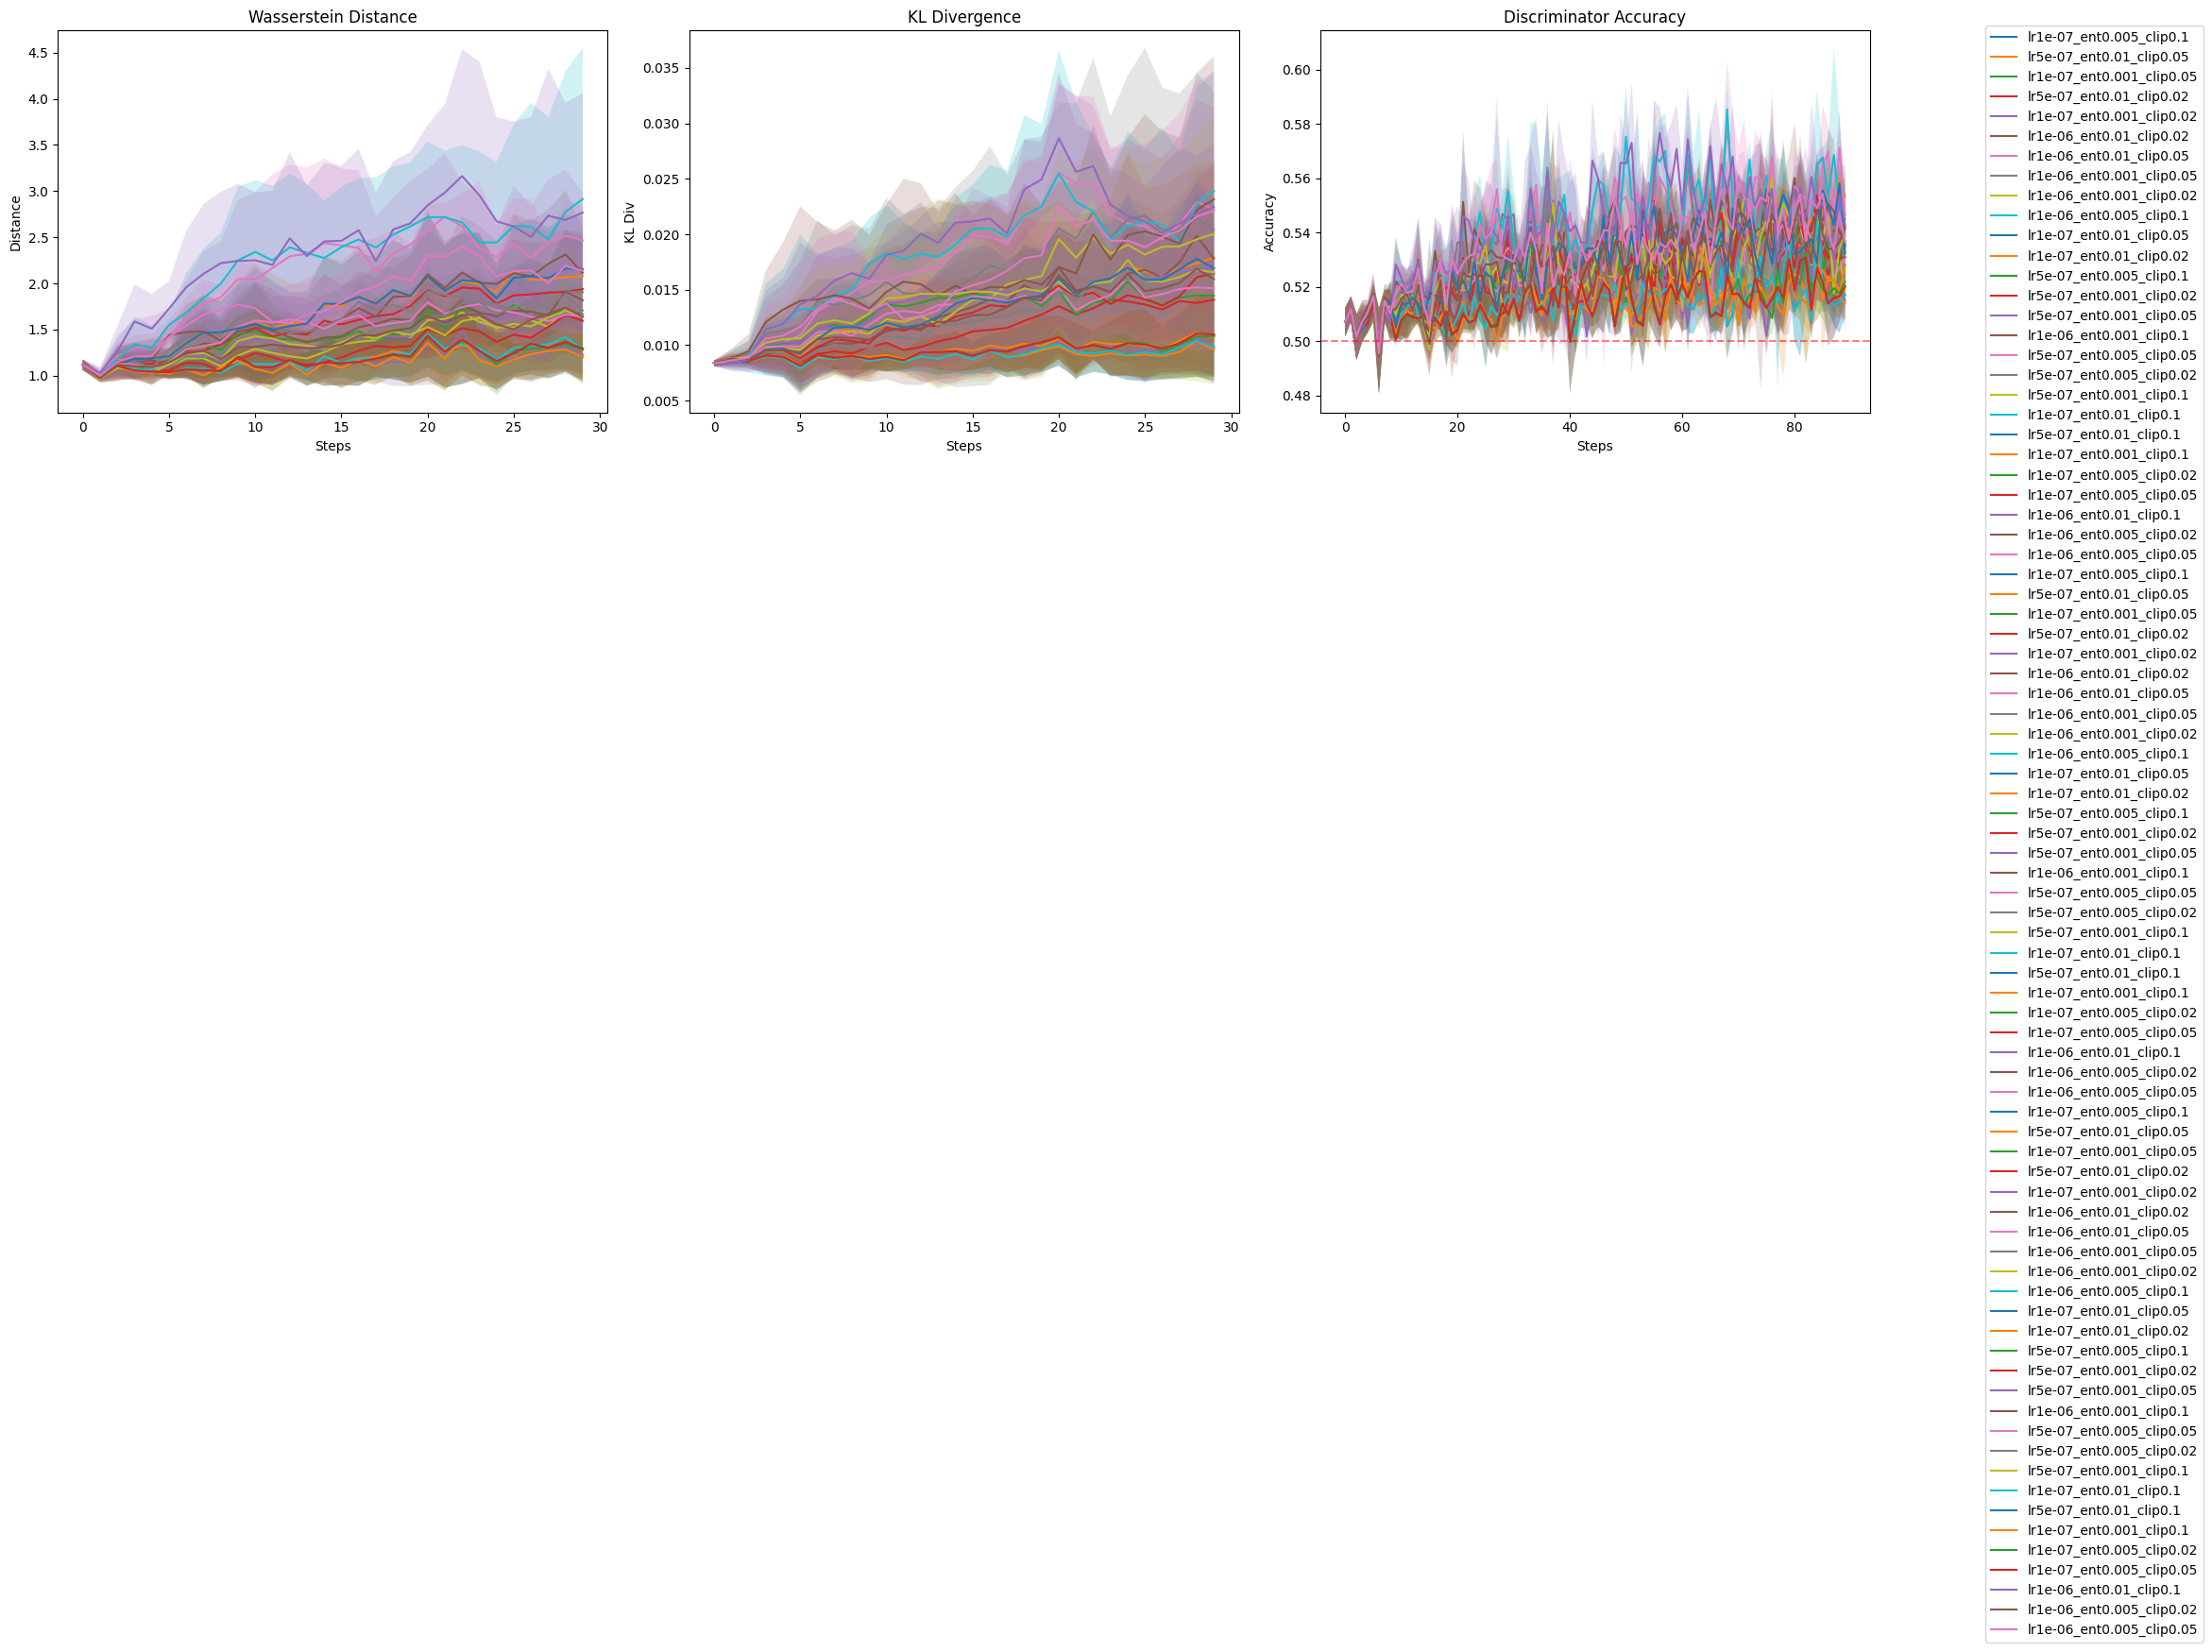


Best configuration: ('lr1e-07_ent0.001_clip0.05', {'full_mean': 1.1369761121273663, 'final_mean': 1.252539377783153})


TypeError: unsupported format string passed to tuple.__format__

In [7]:
# Main analysis
def main():
    base_dir = Path('results')
    all_results = {}
    
    # Process each configuration
    for config_dir in base_dir.iterdir():
        if config_dir.is_dir() and 'lr' in config_dir.name:
            config_name = config_dir.name
            all_results[config_name] = aggregate_seeds(config_dir)
    
    # Plot results
    plot_comparison(all_results)
    
    # Find best configuration
    best_config, best_score = find_best_config(all_results)
    print(f"\nBest configuration: {best_config}")
    print(f"Final Wasserstein score: {best_score:.4f}")

if __name__ == "__main__":
    main()

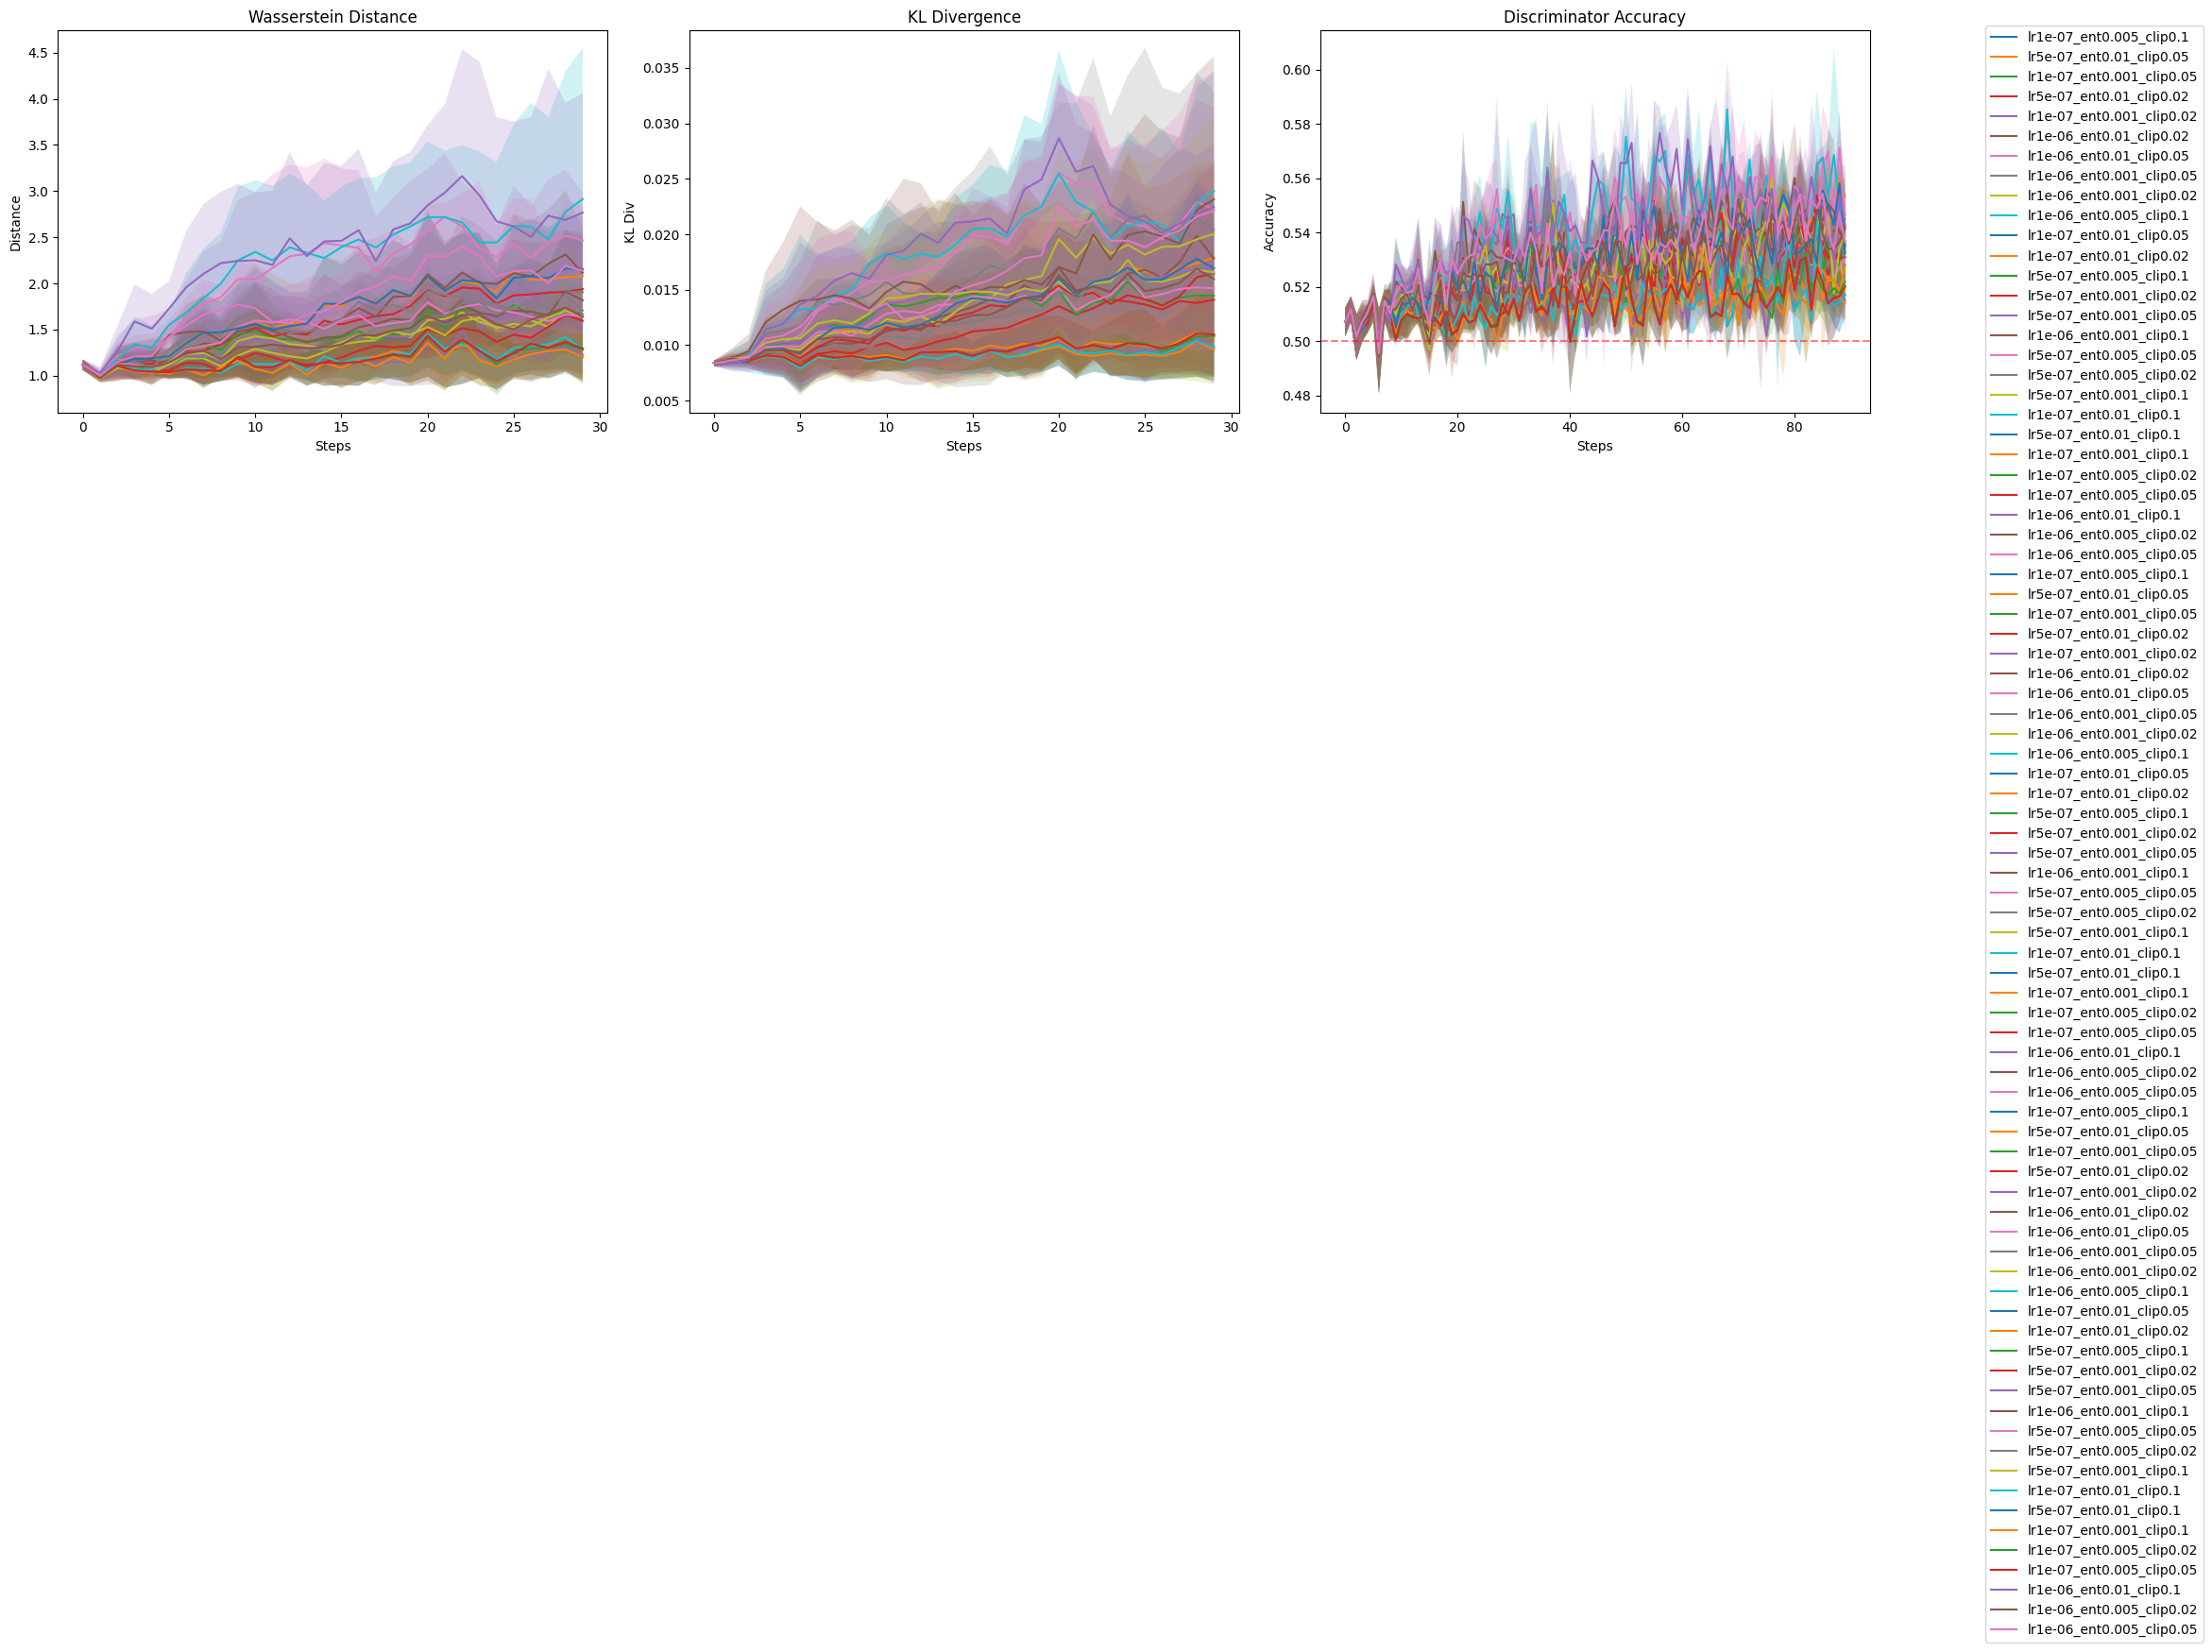


Results based on full training:
Best configuration: lr1e-07_ent0.001_clip0.05
Mean Wasserstein score: 1.1370

Results based on final 10%:
Best configuration: lr1e-07_ent0.001_clip0.05
Final Wasserstein score: 1.2525


In [8]:
def find_best_config(all_results):
    """Find best configuration based on both full and final performance"""
    config_performance = {}
    for config_name, results in all_results.items():
        wasserstein_mean = results['wasserstein']['mean']
        
        # Full training performance
        full_performance = np.mean(wasserstein_mean)
        
        # Final 10% performance
        final_performance = np.mean(wasserstein_mean[-int(len(wasserstein_mean)*0.1):])
        
        config_performance[config_name] = {
            'full_mean': full_performance,
            'final_mean': final_performance
        }
    
    # Find best by both metrics
    best_full = min(config_performance.items(), key=lambda x: x[1]['full_mean'])
    best_final = min(config_performance.items(), key=lambda x: x[1]['final_mean'])
    
    return {
        'best_full_config': best_full[0],
        'best_full_score': best_full[1]['full_mean'],
        'best_final_config': best_final[0],
        'best_final_score': best_final[1]['final_mean']
    }

def main():
    base_dir = Path('results')
    all_results = {}
    
    # Process each configuration
    for config_dir in base_dir.iterdir():
        if config_dir.is_dir() and 'lr' in config_dir.name:
            config_name = config_dir.name
            all_results[config_name] = aggregate_seeds(config_dir)
    
    # Plot results
    plot_comparison(all_results)
    
    # Find best configuration
    best_results = find_best_config(all_results)
    
    print("\nResults based on full training:")
    print(f"Best configuration: {best_results['best_full_config']}")
    print(f"Mean Wasserstein score: {best_results['best_full_score']:.4f}")
    
    print("\nResults based on final 10%:")
    print(f"Best configuration: {best_results['best_final_config']}")
    print(f"Final Wasserstein score: {best_results['best_final_score']:.4f}")

if __name__ == "__main__":
    main()